In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
sys.path.append("../data/biasbios")
sys.path.append("../data/embeddings/biasbios")
import classifier
import debias
import gensim
import codecs
import json
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import DictVectorizer
from pytorch_transformers import BertTokenizer, BertModel, BertForMaskedLM

import scipy
from scipy import linalg
from scipy import sparse
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier, SGDRegressor, Perceptron, LogisticRegression
from sklearn.utils import shuffle

%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000

import warnings
warnings.filterwarnings("ignore")

import pickle
from collections import defaultdict, Counter
from typing import List, Dict

import torch
from torch import utils

# import pytorch_lightning as pl
# from pytorch_lightning import Trainer
import copy
import pandas as pd
from gensim.models import FastText
import time
from gensim.scripts.glove2word2vec import glove2word2vec

STOPWORDS = set(["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"])

In [2]:


def load_dataset(path):
    
    with open(path, "rb") as f:
        
        data = pickle.load(f)
    return data

def load_dictionary(path):
    
    with open(path, "r", encoding = "utf-8") as f:
        
        lines = f.readlines()
        
    k2v, v2k = {}, {}
    for line in lines:
        
        k,v = line.strip().split("\t")
        v = int(v)
        k2v[k] = v
        v2k[v] = k
    
    return k2v, v2k
    
def count_profs_and_gender(data: List[dict]):
    
    counter = defaultdict(Counter)
    for entry in data:
        gender, prof = entry["g"], entry["p"]
        counter[prof][gender] += 1
        
    return counter


In [3]:
train = load_dataset("../data/biasbios/train.pickle")
dev = load_dataset("../data/biasbios/dev.pickle")
test = load_dataset("../data/biasbios/test.pickle")

p2i, i2p = load_dictionary("../data/biasbios/profession2index.txt")
g2i, i2g = load_dictionary("../data/biasbios/gender2index.txt")
counter = count_profs_and_gender(train+dev+test)

In [4]:
train[0]

{'g': 'f',
 'p': 'professor',
 'text': 'Dr. Jessica Orlofske is an Assistant Professor of Biology at the University of Wisconsin-Parkside. Her research program areas include invertebrate biodiversity and conservation and biomonitoring and assessment of ecological integrity. She obtained her PhD from the University of New Brunswick under the direction of Dr. Donald Baird. Dr. Orlofske was also a post-doctoral fellow with the CRI before taking up her current position, making her the first CRI student to become a Science Director.',
 'start': 98,
 'hard_text': 'Her research program areas include invertebrate biodiversity and conservation and biomonitoring and assessment of ecological integrity. She obtained her PhD from the University of New Brunswick under the direction of Dr. Donald Baird. Dr. Orlofske was also a post-doctoral fellow with the CRI before taking up her current position, making her the first CRI student to become a Science Director.',
 'text_without_gender': '_ research pr

In [5]:
print(p2i)

{'accountant': 0, 'architect': 1, 'attorney': 2, 'chiropractor': 3, 'comedian': 4, 'composer': 5, 'dentist': 6, 'dietitian': 7, 'dj': 8, 'filmmaker': 9, 'interior_designer': 10, 'journalist': 11, 'model': 12, 'nurse': 13, 'painter': 14, 'paralegal': 15, 'pastor': 16, 'personal_trainer': 17, 'photographer': 18, 'physician': 19, 'poet': 20, 'professor': 21, 'psychologist': 22, 'rapper': 23, 'software_engineer': 24, 'surgeon': 25, 'teacher': 26, 'yoga_teacher': 27}


In [6]:
counter = count_profs_and_gender(train+dev+test)
f,m = 0., 0.
prof2fem = dict()

for k, values in counter.items():
    f += values['f']
    m += values['m']
    prof2fem[k] = values['f']/(values['f'] + values['m'])

print(f / (f + m))
print(prof2fem)

0.44541700643683746
{'professor': 0.4533699535765501, 'psychologist': 0.627327974906881, 'pastor': 0.2583668005354752, 'comedian': 0.21605667060212513, 'nurse': 0.9126009126009126, 'yoga_teacher': 0.825, 'attorney': 0.3766122913505311, 'photographer': 0.3563658099222953, 'composer': 0.16329625884732052, 'model': 0.7858407079646018, 'surgeon': 0.12832108535895986, 'physician': 0.4158485273492286, 'software_engineer': 0.17130434782608694, 'poet': 0.5133630289532294, 'painter': 0.47116788321167885, 'dj': 0.1636828644501279, 'journalist': 0.5159589626674266, 'architect': 0.23372781065088757, 'paralegal': 0.8618677042801557, 'dentist': 0.3672911787665886, 'personal_trainer': 0.4410377358490566, 'teacher': 0.5943396226415094, 'accountant': 0.3950091296409008, 'interior_designer': 0.7874493927125507, 'dietitian': 0.934412955465587, 'filmmaker': 0.3533007334963325, 'chiropractor': 0.3069908814589666, 'rapper': 0.09438775510204081}


In [7]:
print(p2i)

{'accountant': 0, 'architect': 1, 'attorney': 2, 'chiropractor': 3, 'comedian': 4, 'composer': 5, 'dentist': 6, 'dietitian': 7, 'dj': 8, 'filmmaker': 9, 'interior_designer': 10, 'journalist': 11, 'model': 12, 'nurse': 13, 'painter': 14, 'paralegal': 15, 'pastor': 16, 'personal_trainer': 17, 'photographer': 18, 'physician': 19, 'poet': 20, 'professor': 21, 'psychologist': 22, 'rapper': 23, 'software_engineer': 24, 'surgeon': 25, 'teacher': 26, 'yoga_teacher': 27}


### get input representatons 

In [8]:

def load_word_vectors(fname):
    
    model = KeyedVectors.load_word2vec_format(fname, binary=False)
    vecs = model.vectors
    words = list(model.vocab.keys())
    return model, vecs, words


def get_embeddings_based_dataset(data: List[dict], word2vec_model, p2i, filter_stopwords = False):
    
    X, Y = [], []
    unk, total = 0., 0.
    unknown = []
    vocab_counter = Counter()
    
    for entry in tqdm.tqdm_notebook(data, total = len(data)):
        
        y = p2i[entry["p"]]
        words = entry["hard_text_tokenized"].split(" ")
        if filter_stopwords:
            words = [w for w in words if w.lower() not in STOPWORDS]
            
        vocab_counter.update(words) 
        bagofwords = np.sum([word2vec_model[w] if w in word2vec_model else word2vec_model["unk"] for w in words], axis = 0)
        #print(bagofwords.shape)
        X.append(bagofwords)
        Y.append(y)
        total += len(words)
        
        unknown_entry = [w for w in words if w not in word2vec_model]
        unknown.extend(unknown_entry)
        unk += len(unknown_entry)
    
    X = np.array(X)
    Y = np.array(Y)
    print("% unknown: {}".format(unk/total))
    return X,Y,unknown,vocab_counter



In [9]:
word2vec, vecs, words = load_word_vectors("../data/embeddings/crawl-300d-2M.vec")

In [10]:
x_train, y_train, unknown_train, vocab_counter_train = get_embeddings_based_dataset(train, word2vec, p2i)
x_dev, y_dev, unknown_dev, vocab_counter_dev =  get_embeddings_based_dataset(dev, word2vec, p2i)
x_test, y_test, unknown_test, vocab_counter_test =  get_embeddings_based_dataset(test, word2vec, p2i)

  0%|          | 0/74882 [00:00<?, ?it/s]

% unknown: 0.010167678378823583


  0%|          | 0/11550 [00:00<?, ?it/s]

% unknown: 0.010116209992979287


  0%|          | 0/28842 [00:00<?, ?it/s]

% unknown: 0.01018950257509165


In [11]:
# def save_in_word2vec_format(vecs: np.ndarray, words: np.ndarray, fname: str):


#     with open(fname, "w", encoding = "utf-8") as f:

#         f.write(str(len(vecs)) + " " + "300" + "\n")
#         for i, (v,w) in tqdm.tqdm_notebook(enumerate(zip(vecs, words))):

#             vec_as_str = " ".join([str(x) for x in v])
#             f.write(w + " " + vec_as_str + "\n")


# vocab_bios, _ = list(zip(*vocab_counter_train.most_common(120000)))
# words_set = set(words)
# vocab_bios = [w for w in tqdm.tqdm_notebook(vocab_bios) if w in words_set]
# vecs_for_vocab = np.array([word2vec[w] for w in tqdm.tqdm_notebook(vocab_bios)])
# print("here")
# save_in_word2vec_format(vecs_for_vocab, vocab_bios, "vecs.vocab.bios.txt")
# word2vec_bios, _, _ = load_word_vectors("vecs.vocab.bios.txt")

In [12]:
print("len train: {}; len dev: {}; len test: {}".format(len(train), len(dev), len(test)))
mean_train = np.mean(x_train, axis = 0, keepdims = True)
mean_dev = np.mean(x_dev, axis = 0, keepdims = True)
mean_test = np.mean(x_test, axis = 0, keepdims = True)

#X_train -= mean_train
#X_dev -= mean_dev
#X_test -= mean_test

len train: 74882; len dev: 11550; len test: 28842


In [13]:
print("len train: {}; len dev: {}; len test: {}".format(len(train), len(dev), len(test)))
mean_train = np.mean(x_train, axis = 0, keepdims = True)
mean_dev = np.mean(x_dev, axis = 0, keepdims = True)
mean_test = np.mean(x_test, axis = 0, keepdims = True)

#X_train -= mean_train
#X_dev -= mean_dev
#X_test -= mean_test

len train: 74882; len dev: 11550; len test: 28842


## Classify by profession

In [14]:
#clf = LinearSVC(max_iter = 10) #LogisticRegression()
#clf = SGDClassifier(warm_start = True, loss = 'log', n_jobs = 64, max_iter = 250, random_state = 0)

clf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", multi_class = 'multinomial', fit_intercept = True,
                         verbose = 10, max_iter = 4, n_jobs = 64, random_state = 1)
#clf = SGDClassifier(loss= 'log', max_iter= 3000, fit_intercept= True, class_weight= None, n_jobs= 100)
#clf = LinearSVC(max_iter = 50) #LogisticRegression()

start = time.time()
idx = np.random.rand(x_train.shape[0]) < 1.0
clf.fit(x_train[idx], y_train[idx])
print("time: {}".format(time.time() - start))
print(clf.score(x_dev, y_dev))
#print(clf.score(X_test, Y_test))
clf_original = copy.deepcopy(clf)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 17 seconds
time: 17.493760347366333
0.7554112554112554


[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:   17.3s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   17.3s finished


In [15]:
print(clf.score(x_test, y_test))

0.7553914430344636


### perform debiasing

In [16]:
y_dev_gender = np.array([g2i[d["g"]] for d in dev])
y_test_gender = np.array([g2i[d["g"]] for d in test])
y_train_gender = np.array([g2i[d["g"]] for d in train])
y_train_gender_2d = np.asarray([y_train_gender, - y_train_gender + 1]).T

In [17]:
y_dev_gender.shape, y_train_gender.shape, y_test_gender.shape

((11550,), (74882,), (28842,))

In [18]:
t = time.time()
A = np.dot(x_train.T, y_train_gender_2d) / x_train.shape[0]
u, s, vh = np.linalg.svd(A, full_matrices=True)
elapsed = time.time() - t
print(f"sal took {elapsed} seconds")
print(f"u has shape {u.shape}, s has shape {s.shape}, vh has shape {vh.shape}")

sal took 0.1637871265411377 seconds
u has shape (300, 300), s has shape (2,), vh has shape (2, 2)


In [ ]:
# To save the model

# removal = 1
# u_r = u[:, removal:]
# proj = u_r @ u_r.T
# P = proj

# debiased_x_train_1 = P.dot(x_train.T).T
# debiased_x_dev_1 = P.dot(x_dev.T).T
# debiased_x_test_1 = P.dot(x_test.T).T

# removal = 2
# u_r = u[:, removal:]
# proj = u_r @ u_r.T
# P = proj

# debiased_x_train_2 = P.dot(x_train.T).T
# debiased_x_dev_2 = P.dot(x_dev.T).T
# debiased_x_test_2 = P.dot(x_test.T).T

# rm -rf FastText.npz

# np.savez("FastText.npz", u = u, s = s, vh = vh, 
#          x_train = x_train, x_test = x_test, 
#          debiased_x_train_1 = debiased_x_train_1, debiased_x_test_1 = debiased_x_test_1, 
#          debiased_x_train_2 = debiased_x_train_2, debiased_x_test_2 = debiased_x_test_2, 
#          y_train_gender = y_train_gender, y_train = y_train, 
#          y_test_gender = y_test_gender, y_test = y_test)


### Perform finetuning

In [ ]:

# clf = LogisticRegression(warm_start = True, penalty = 'l2',
#                          solver = "sag", multi_class = 'multinomial', fit_intercept = True,
#                          verbose = 10, max_iter = 6, n_jobs = 64, random_state = 0, class_weight = None)

# clf.fit(debiased_x_train, y_train)

# print(clf.score(debiased_x_test, y_test))

#### test again

In [21]:
def get_TPR(y_pred, y_true, p2i, i2p, gender):
    
    scores = defaultdict(Counter)
    prof_count_total = defaultdict(Counter)
    
    assert len(y_pred) == len(y_true) == len(gender)
               
    for y_hat, y, g in zip(y_pred, y_true, gender):
                
        if y == y_hat:
            
            scores[i2p[y]][g] += 1
        
        prof_count_total[i2p[y]][g] += 1
    
    tprs = defaultdict(dict)
    tprs_change = dict()
    tprs_ratio = []
    
    for profession, scores_dict in scores.items():
        
        good_m, good_f = scores_dict["m"], scores_dict["f"]
        prof_total_f = prof_count_total[profession]["f"]
        prof_total_m = prof_count_total[profession]["m"]
        tpr_m = (good_m) / prof_total_m
        tpr_f = (good_f) / prof_total_f
        
        tprs[profession]["m"] = tpr_m
        tprs[profession]["f"] = tpr_f
        tprs_ratio.append(0)
        tprs_change[profession] = tpr_f - tpr_m
        
    return tprs, tprs_change, np.mean(np.abs(tprs_ratio))

def get_FPR(y_pred, y_true, p2i, i2p, gender):
    
    fp = defaultdict(Counter)
    neg_count_total = defaultdict(Counter)
    pos_count_total = defaultdict(Counter)
    
    
               
    for y_hat, y, g in zip(y_pred, y_true, gender):
        
        if y != y_hat:
            
            fp[i2p[y_hat]][g] += 1 # count false positives for y_hat
        
        neg_count_total[i2p[y_hat]][g] += 1 # count "not y_hat"
                
    fprs = defaultdict(dict)
    fprs_change = dict()
    fprs_ratio = []
    
    #print(prof_count_total)
    
    for profession, scores_dict in fp.items():
        
        good_m, good_f = scores_dict["m"], scores_dict["f"]
        prof_total_f = neg_count_total[profession]["f"]
        prof_total_m = neg_count_total[profession]["m"]
        print(profession)
        fpr_m = (good_m+good_f) / prof_total_m
        fpr_f = (good_m+good_f) / prof_total_f
        
        fprs[profession]["m"] = fpr_m
        fprs[profession]["f"] = fpr_f
        fprs_ratio.append(0)
        fprs_change[profession] = fpr_m - fpr_f
        
    return fprs, fprs_change, np.mean(np.abs(fprs_ratio))    
    
def similarity_vs_tpr(tprs, word2vec, title, measure, prof2fem):
    
    professions = list(tprs.keys())
    #
    """ 
    sims = dict()
    gender_direction = word2vec["he"] - word2vec["she"]
    
    for p in professions:
        sim = word2vec.cosine_similarities(word2vec[p], [gender_direction])[0]
        sims[p] = sim
    """
    tpr_lst = [tprs[p] for p in professions]
    sim_lst = [prof2fem[p] for p in professions]

    #professions = [p.replace("_", " ") for p in professions if p in word2vec]
    
    plt.plot(sim_lst, tpr_lst, marker = "o", linestyle = "none")
    plt.xlabel("% women", fontsize = 13)
    plt.ylabel(r'$GAP_{female,y}^{TPR}$', fontsize = 13)
    for p in professions:
        x,y = prof2fem[p], tprs[p]
        plt.annotate(p , (x,y), size = 7, color = "red")
    
    plt.ylim(-0.4,0.55)
    z = np.polyfit(sim_lst, tpr_lst, 1)
    p = np.poly1d(z)
    plt.plot(sim_lst,p(sim_lst),"b--")

    plt.savefig("{}_vs_bias_{}_fasttext".format(measure, title), dpi = 600)
    print("Correlation: {}; p-value: {}".format(*pearsonr(sim_lst, tpr_lst)))
    plt.show()
    
def rms_diff(tpr_diff):
    
    return np.sqrt(np.mean(tpr_diff**2))
    
def save_vecs_and_words(vecs, words):
    def to_string(arr):
        return "\t".join([str(x) for x in arr])
    
    with open("vecs.txt", "w") as f:
        for v in vecs:
            assert len(v) == 300
            f.write(to_string(v) + "\n")
    
    with open("labels.txt", "w") as f:
            f.write("Profession\n")
            for w in words:
                f.write(w + "\n")

In [33]:
removal = 1
u_r = u[:, removal:]
proj = u_r @ u_r.T
P = proj

debiased_x_train = P.dot(x_train.T).T
debiased_x_dev = P.dot(x_dev.T).T
debiased_x_test = P.dot(x_test.T).T

Correlation: 0.8229158334674403; p-value: 7.657770186244778e-08


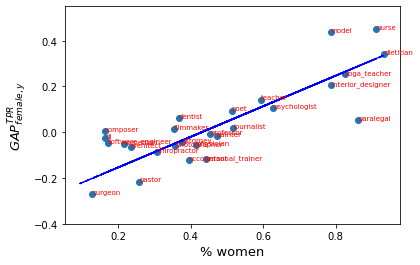

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 26 seconds


[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:   25.9s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   25.9s finished


Correlation: 0.8414221239242293; p-value: 2.0380691845191047e-08


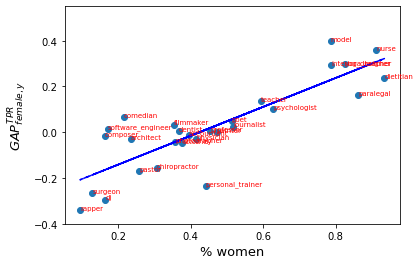

rms-diff before: 0.20125138721368724; rms-diff after: 0.18630195968662291


In [34]:
y_pred_before = clf_original.predict(x_test)
test_gender = [d["g"] for d in test]
dev_gender = [d["g"] for d in dev]
train_gender = [d["g"] for d in train]

tprs_before, tprs_change_before, mean_ratio_before = get_TPR(y_pred_before, y_test, p2i, i2p, test_gender)
similarity_vs_tpr(tprs_change_before, word2vec, "before", "TPR", prof2fem)

clf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", multi_class = 'multinomial', fit_intercept = True,
                         verbose = 10, max_iter = 6, n_jobs = 64, random_state = 0, class_weight = None)
clf.fit(debiased_x_train, y_train)
y_pred_after = clf.predict(debiased_x_test)

tprs, tprs_change_after, mean_ratio_after = get_TPR(y_pred_after, y_test, p2i, i2p, test_gender)
similarity_vs_tpr(tprs_change_after, word2vec, "after", "TPR", prof2fem)

change_vals_before = np.array(list((tprs_change_before.values())))
change_vals_after = np.array(list(tprs_change_after.values()))

print("rms-diff before: {}; rms-diff after: {}".format(rms_diff(change_vals_before), rms_diff(change_vals_after)))

In [35]:
clf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", multi_class = 'multinomial', fit_intercept = True,
                         verbose = 10, max_iter = 6, n_jobs = 64, random_state = 0, class_weight = None)

clf.fit(debiased_x_train, y_train)

print(clf.score(debiased_x_test, y_test))

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 26 seconds
0.7596907287982803


[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:   26.2s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   26.2s finished


In [36]:
removal = 2
u_r = u[:, removal:]
proj = u_r @ u_r.T
P = proj

debiased_x_train = P.dot(x_train.T).T
debiased_x_dev = P.dot(x_dev.T).T
debiased_x_test = P.dot(x_test.T).T

Correlation: 0.8229158334674403; p-value: 7.657770186244778e-08


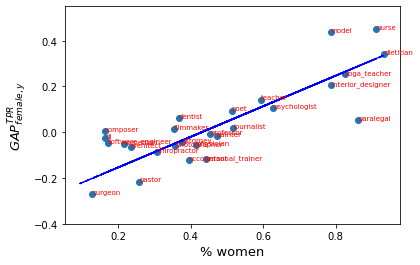

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 26 seconds


[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:   25.9s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   25.9s finished


Correlation: 0.5988793708459228; p-value: 0.0007596910522041412


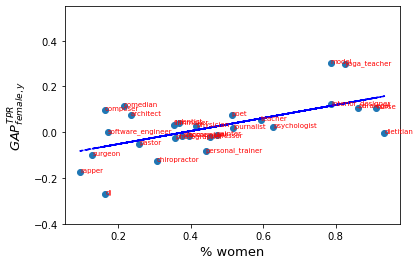

rms-diff before: 0.20125138721368724; rms-diff after: 0.11933701391761586


In [37]:
y_pred_before = clf_original.predict(x_test)
test_gender = [d["g"] for d in test]
dev_gender = [d["g"] for d in dev]
train_gender = [d["g"] for d in train]

tprs_before, tprs_change_before, mean_ratio_before = get_TPR(y_pred_before, y_test, p2i, i2p, test_gender)
similarity_vs_tpr(tprs_change_before, word2vec, "before", "TPR", prof2fem)

clf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", multi_class = 'multinomial', fit_intercept = True,
                         verbose = 10, max_iter = 6, n_jobs = 64, random_state = 0, class_weight = None)
clf.fit(debiased_x_train, y_train)
y_pred_after = clf.predict(debiased_x_test)

tprs, tprs_change_after, mean_ratio_after = get_TPR(y_pred_after, y_test, p2i, i2p, test_gender)
similarity_vs_tpr(tprs_change_after, word2vec, "after", "TPR", prof2fem)

change_vals_before = np.array(list((tprs_change_before.values())))
change_vals_after = np.array(list(tprs_change_after.values()))

print("rms-diff before: {}; rms-diff after: {}".format(rms_diff(change_vals_before), rms_diff(change_vals_after)))

In [38]:
clf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", multi_class = 'multinomial', fit_intercept = True,
                         verbose = 10, max_iter = 6, n_jobs = 64, random_state = 0, class_weight = None)

clf.fit(debiased_x_train, y_train)

print(clf.score(debiased_x_test, y_test))

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 26 seconds
0.7558075029470911


[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:   25.8s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   25.8s finished


In [ ]:
removal = 20
u_r = u[:, removal:]
proj = u_r @ u_r.T
P = proj

debiased_x_train = P.dot(x_train.T).T
debiased_x_dev = P.dot(x_dev.T).T
debiased_x_test = P.dot(x_test.T).T

In [ ]:
y_pred_before = clf_original.predict(x_test)
test_gender = [d["g"] for d in test]
dev_gender = [d["g"] for d in dev]
train_gender = [d["g"] for d in train]

tprs_before, tprs_change_before, mean_ratio_before = get_TPR(y_pred_before, y_test, p2i, i2p, test_gender)
similarity_vs_tpr(tprs_change_before, word2vec, "before", "TPR", prof2fem)
#y_pred_after = clf.predict(X_test.dot(P))
y_pred_after = clf.predict(debiased_x_test)
tprs, tprs_change_after, mean_ratio_after = get_TPR(y_pred_after, y_test, p2i, i2p, test_gender)
similarity_vs_tpr(tprs_change_after, word2vec, "after", "TPR", prof2fem)

change_vals_before = np.array(list((tprs_change_before.values())))
change_vals_after = np.array(list(tprs_change_after.values()))

print("rms-diff before: {}; rms-diff after: {}".format(rms_diff(change_vals_before), rms_diff(change_vals_after)))

In [ ]:
clf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", multi_class = 'multinomial', fit_intercept = True,
                         verbose = 10, max_iter = 6, n_jobs = 64, random_state = 0, class_weight = None)

clf.fit(debiased_x_train, y_train)

print(clf.score(debiased_x_test, y_test))

In [ ]:
clf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", multi_class = 'multinomial', fit_intercept = True,
                         verbose = 10, max_iter = 6, n_jobs = 64, random_state = 0, class_weight = None)

clf.fit(x_train, y_train)

print(f"Biased Train accuracy {clf.score(x_train, y_train)}")
print(f"Biased Test accuracy {clf.score(x_test, y_test)}")
print(f"Train accuracy {clf.score(debiased_x_train, y_train)}")
print(f"Test accuracy {clf.score(debiased_x_test, y_test)}")